In [1]:
import sys, time, os, asyncio
import scipy.stats as stats
from scipy import signal
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, clipDataToEvent, calcNextDay
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_freq_psd(vals, timestep):

    """
    Calculates the frequency power spectrum of a signal.

    Args:
        vals (np.array): The signal values.
        timestep (float): The time step between samples.

    Returns:
        tuple: The frequencies and power spectral density.
    """

    # Remove the mean from the signal.

    meanval = np.mean(vals)
    signal = vals - meanval

    # Calculate the length of the signal.

    N = len(signal)

    # Calculate the power spectral density.

    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2

    # Calculate the frequencies.

    frequencies = np.fft.rfftfreq(N, timestep)

    return (frequencies, psd)

def get_efd_data(begin, end, client):

    """Extract all the MTMount data from the EFD and add to dict.

    Args:
        begin (str): The start time of the query.
        end (str): The end time of the query.
        client (object): influx client

    Returns:
        dict: A dictionary containing the MTMount data.
    """

    query_dict = {}

    query_dict["el"] = getEfdData(
        client,
        "lsst.sal.MTMount.elevation",
        columns=["private_sndStamp", "private_efdStamp", "actualPosition", "actualVelocity", "actualTorque"],
        begin=begin,
        end=end,
        prePadding=0,
        postPadding=0,
        warn=False,
    )
    query_dict["az"] = getEfdData(
        client,
        "lsst.sal.MTMount.azimuth",
        columns=["private_sndStamp", "private_efdStamp", "actualPosition", "actualVelocity", "actualTorque"],
        begin=begin,
        end=end,
        prePadding=0,
        postPadding=0,
        warn=False,
    )
    return query_dict

def get_vms_data(filename, begin_time, end_time):

    """Extract VMS data from a HDF5 file.

    Args:
        filename (str): The path to the HDF5 file.
        begin_time (float): The start time of the query (unix, utc).
        end_time (float): The end time of the query (unix, utc).

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the VMS data.
    """

    f = h5py.File(filename, 'r')
    times = f['timestamp'][::1]
    mkeys = [1, 2, 3]
    dkeys = 'XYZ'
    sel = (times > begin_time) & (times < end_time)
    data_dict = {}
    data_dict['times'] = times[sel]  
    for i, m in enumerate(mkeys):
        for j, d in enumerate(dkeys):
            key = f'{m} {d}'
            data_dict[key_dict[key]] = f[key][::1][sel]
    data_frame = pd.DataFrame(data_dict)
    return data_frame

In [3]:
key_dict={'1 X': 'm1m3_x', 
          '1 Y': 'm1m3_y', 
          '1 Z': 'm1m3_z', 
          '2 X': 'm2_x', 
          '2 Y': 'm2_y', 
          '2 Z': 'm2_z', 
          '3 X': 'cr_x', 
          '3 Y': 'cr_y', 
          '3 Z': 'cr_z'
}
vms_filename="/home/p/pferguso/u/scratch/M1M3-2023-06-28T0000.hdf"

### setup tma events

For this test we wanted, force balance on, mirror raised, and no slew
for the time range '2023-06-28 00:13:30'- '2023-06-28 00:15:00'

- assuming "lsst.sal.MTM1M3.appliedBalanceForces" being nonzero means the force balance is on then: https://usdf-rsp.slac.stanford.edu/chronograf/sources/1/chronograf/data-explorer?query=SELECT%20%22fx%22%2C%20%22fy%22%2C%20%22fz%22%20FROM%20%22efd%22.%22autogen%22.%22lsst.sal.MTM1M3.appliedBalanceForces%22%20WHERE%20time%20%3E%20%3AdashboardTime%3A%20AND%20time%20%3C%20%3AupperDashboardTime%3A#
- mirror was raised at 06/27/2023 19:39:10 and not lowered according to "lsst.sal.MTM1M3.command_raiseM1M3"
- telescope was between slews
  

In [5]:
dayObs=20230628
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)
slews=[e for e in events if e.type==TMAState.SLEWING]

### query data

In [39]:
begin_time=Time('2023-06-28 00:13:30', format="iso", scale="utc")
end_time=Time('2023-06-28 00:15:00', format="iso", scale="utc")
efd_dict=get_efd_data(begin_time, end_time, eventMaker.client)
vms_data=get_vms_data(vms_filename, begin_time.unix, end_time.unix)

### Plots
 - First plot is just plotting the vms data (and elevation telemetry)
 - second plot is spectrograms of the vms data
 - third plot a psd of all the vms data

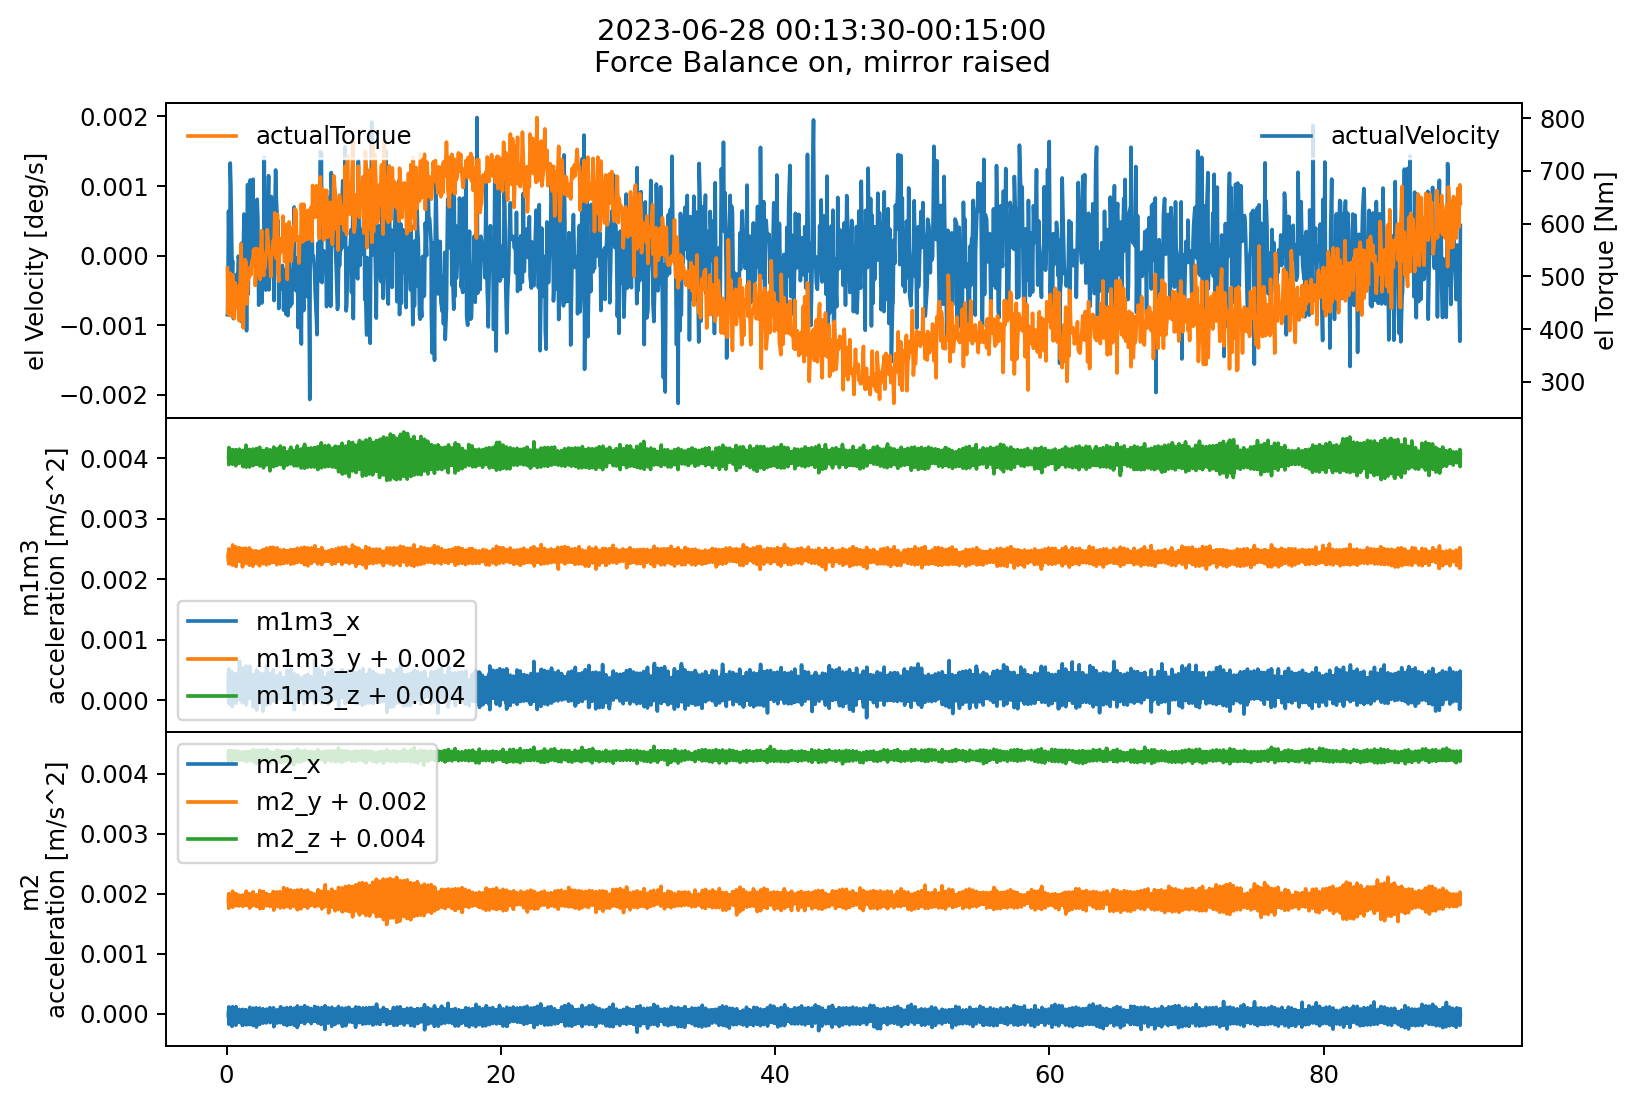

In [40]:
fig, ax=plt.subplots(3, dpi=175, sharex=True, figsize=(10,7))
plt.suptitle(f"{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\nForce Balance on, mirror raised", y=0.95)
ax[0].plot((Time(efd_dict["el"]["private_sndStamp"], format="unix_tai", scale="utc")- begin_time).sec,
           efd_dict["el"]["actualVelocity"],
           color="tab:blue", label="actualVelocity")
ax[0].legend(edgecolor="white", loc=1)
ax[0].set_ylabel("el Velocity [deg/s]")

ax2=ax[0].twinx()
ax2.plot((Time(efd_dict["el"]["private_sndStamp"], format="unix_tai", scale="utc")- begin_time).sec,
         efd_dict["el"]["actualTorque"],
         color="tab:orange", label="actualTorque")
ax2.legend(edgecolor="white", loc=2)
ax2.set_ylabel("el Torque [Nm]")

ax[1].plot((Time(vms_data["times"], format="unix")- begin_time).sec, 
           vms_data["m1m3_x"],
           label="m1m3_x")
ax[1].plot((Time(vms_data["times"], format="unix")- begin_time).sec, 
           vms_data["m1m3_y"] + 0.002,
           label="m1m3_y + 0.002")
ax[1].plot((Time(vms_data["times"], format="unix")- begin_time).sec, 
           vms_data["m1m3_z"] + 0.004,
           label="m1m3_z + 0.004"
          
          )
ax[1].legend()
ax[1].set_ylabel("m1m3\nacceleration [m/s^2]")

ax[2].plot((Time(vms_data["times"], format="unix")- begin_time).sec, 
           vms_data["m2_x"],
           label="m2_x")
ax[2].plot((Time(vms_data["times"], format="unix")- begin_time).sec, 
           vms_data["m2_y"] + 0.002,
           label="m2_y + 0.002")
ax[2].plot((Time(vms_data["times"], format="unix")- begin_time).sec, 
           vms_data["m2_z"] + 0.004,
           label="m2_z + 0.004"
          
          )
ax[2].legend()
ax[2].set_ylabel("m2\nacceleration [m/s^2]")
ax[2]
plt.subplots_adjust(hspace=0)
plt.savefig("./efd_and_vms.png", facecolor="white")

In [41]:
fs=1/np.mean(np.diff(vms_data["times"]))

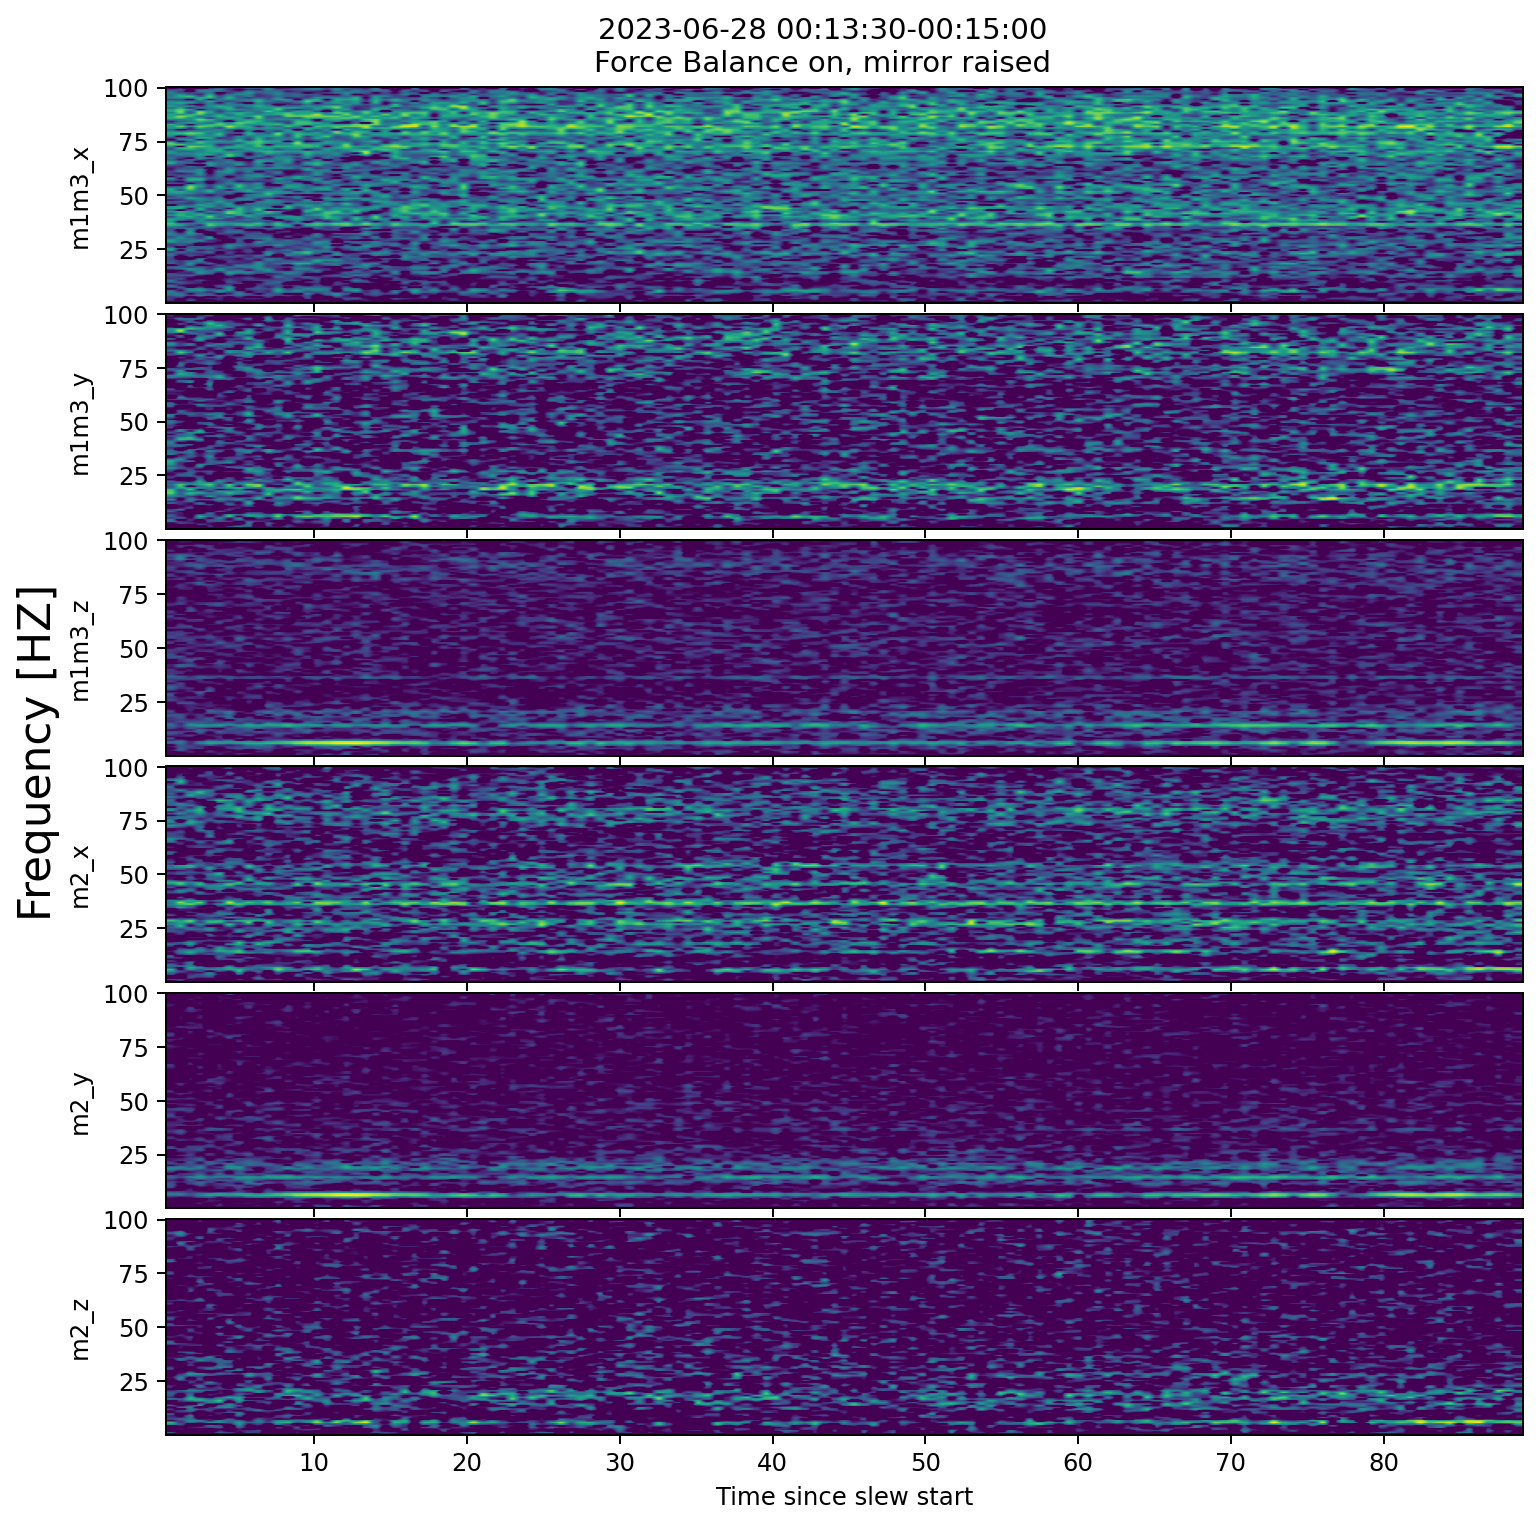

In [44]:

fig,axs=plt.subplots(6, dpi=175, figsize=(10,10), sharex=True)
plt.suptitle(f"{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\nForce Balance on, mirror raised", y=0.92)
for i,key in enumerate([i for i in key_dict.values() if ("m1m3" in i) or ("m2" in i)]):
    ax=axs[i]
    ax.specgram(vms_data[key], Fs=fs, detrend="mean", vmin=-110)
    ax.set_ylabel(key)
    ax.set_yticks(np.arange(25,125,25))

ax.set_xlabel("Time since slew start")
plt.subplots_adjust(hspace=0.05)
fig.text(0.04, 0.5, 'Frequency [HZ]', va='center', rotation='vertical', fontsize=18)
plt.savefig("./spectrogram_vms.png", facecolor="white")

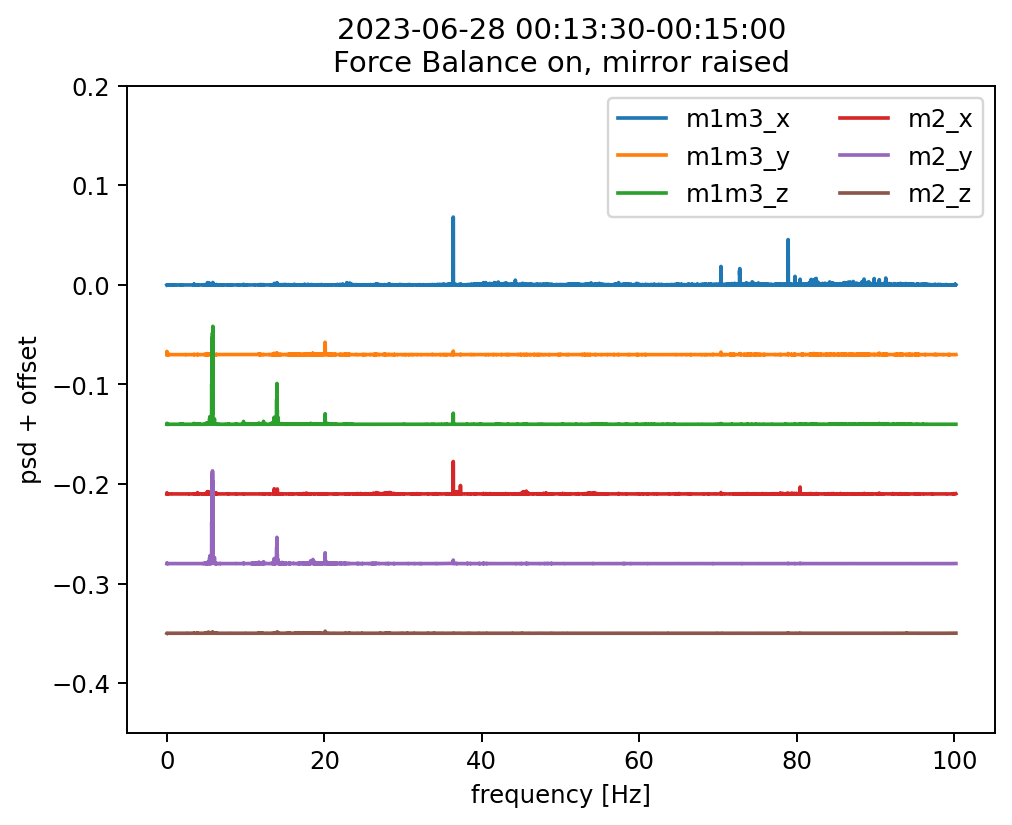

In [45]:
plt.figure(dpi=175)
plt.title(f"{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\nForce Balance on, mirror raised")
step=0.07
for i,key in enumerate([i for i in key_dict.values() if ("m1m3" in i) or ("m2" in i)]):
    
    freq,psd=get_freq_psd(vms_data[key], np.mean(np.diff(vms_data["times"])))
    if key=="m2_x":
        plt.plot(freq,psd - i * step, label=key, zorder=1)
    else:
        plt.plot(freq,psd - i * step, label=key, zorder=9)
plt.legend(ncol=2)
plt.ylim(-0.1 - i * step, 0.2)
plt.xlabel("frequency [Hz]")
plt.ylabel("psd + offset")
plt.savefig("./psd_vms.png", facecolor="white")